In [1]:
# Change these to the raster to be classified and the traindata csv
# If necessary, perform sampling on the raster to produce the traindata csv
# with scripts\01_preprocessing\sample_raster.py

RASTER_PATH = r'E:\pekkah\datat_2806\datacube_Invluokka_koko_alue_yllaspallas_eikrfeno_ei0aa.img'

TRAINDATA_PATH = r'E:\mikkoi\lappi-eo\2806suo_koealat.csv'

In [2]:
# Tästä solusta näkee kuka on viimeksi ajanut notebookin, jotta vältytään mahdollisesti päällekkäin ajamiselta
# E1007914 = mikko i
import os
from datetime import datetime
print(os.environ.get('USERNAME'))
t = datetime.now()
timestamp = t.strftime('%Y-%m-%dT%H-%M-%S')
print(timestamp)

harma
2022-07-08T12-51-57


In [3]:
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import rioxarray
import rasterio as rio
from dask.diagnostics import ProgressBar
from dask.distributed import progress, wait
import dask

import itertools
from tqdm.notebook import tqdm

# https://github.com/joblib/joblib/issues/1021#issuecomment-602586791
# https://github.com/dask/dask/issues/5993

In [4]:
# Dask related environment variables
%env MALLOC_TRIM_THRESHOLD_=0
%env OMP_NUM_THREADS=1
%env MKL_NUM_THREADS=1
%env OPENBLAS_NUM_THREADS=1

env: MALLOC_TRIM_THRESHOLD_=0
env: OMP_NUM_THREADS=1
env: MKL_NUM_THREADS=1
env: OPENBLAS_NUM_THREADS=1


In [5]:
processes = False
threads_per_worker = None

In [6]:
from dask.distributed import Client, LocalCluster, Lock

#n_workers
#memory_limit
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=processes, threads_per_worker=threads_per_worker)
client = Client(cluster)
client.cluster

In [7]:
# rio/dask read/write instructions https://corteva.github.io/rioxarray/stable/examples/dask_read_write.html
chunk_s = 2**10
xds = rioxarray.open_rasterio(RASTER_PATH, 
                              chunks={'band': -1, 'x': chunk_s, 'y': chunk_s},
                              lock=False,
                              parallel=True)
xds

,Array,Chunk
Bytes,19.00 GiB,20.00 MiB
Shape,"(20, 28256, 36108)","(20, 1024, 1024)"
Count,1009 Tasks,1008 Chunks
Type,uint8,numpy.ndarray


## Classification

In [8]:
import pandas as pd

from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                            cohen_kappa_score,
                            make_scorer)
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
from pprint import pprint

from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import dask.array as da

In [9]:
df = pd.read_csv(TRAINDATA_PATH)
df

,Invluokka,lash,s1vv,s1vh,s1ratio,ndmi-md,ndbi-md,ndbi-min,ndti-md,ndti-min,...,s2pc1,s2pc2,s2pc3,s2pc5,maxv,ampl,trop,ndmi-std,slope,osite1-5
0,333,1,124,90,62,99,64,38,131,122,...,153,103,133,124,116,116,115,185,1,1
1,333,1,120,82,61,106,55,44,130,123,...,151,100,107,112,146,148,147,210,1,1
2,333,1,126,96,63,125,29,6,131,127,...,163,147,98,131,145,148,137,198,2,1
3,333,3,133,115,65,115,25,9,134,128,...,164,131,140,129,214,221,179,141,2,1
4,333,2,130,95,60,117,33,15,132,127,...,166,123,93,97,173,178,162,182,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,332,3,129,91,60,98,54,37,132,124,...,157,68,171,175,134,136,132,168,4,1
447,333,2,128,89,60,97,61,37,133,127,...,151,78,153,111,124,125,122,220,1,1
448,323,4,124,98,64,113,31,21,134,123,...,165,98,95,161,150,153,151,178,3,5
449,313,28,141,121,63,121,19,8,137,128,...,176,159,72,149,185,184,177,224,14,5


In [10]:
# Read csv
dfY = df.iloc[:,0]
dfX = df.iloc[:,1:]

# Print info
print("Columns. First one is chosen as target")
print("Index\t\tColumn")
for i, col in enumerate(df.columns):
    print(f"{i}\t\t{col}")
print()

print("\nTarget class distribution")
print("label\tcount")
print(dfY.value_counts())
print()

# Classes smaller than 6 are removed
drop_classes = dfY.value_counts()[dfY.value_counts()<6].index.values
drop_series = ~dfY.isin(drop_classes)

dfY = dfY.loc[drop_series]
dfX = dfX.loc[drop_series,:]

print("Classes smaller than 6 are removed:")
print(drop_classes)
print()

# Final dataset
X = dfX.to_numpy(dtype=xds.dtype)
y = dfY.to_numpy()

le = LabelEncoder()
y = le.fit_transform(y)

print(f"Shape of X: {X.shape}")
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('label mapping:')
pprint(le_name_mapping)

Columns. First one is chosen as target
Index		Column
0		Invluokka
1		lash
2		s1vv
3		s1vh
4		s1ratio
5		ndmi-md
6		ndbi-md
7		ndbi-min
8		ndti-md
9		ndti-min
10		ndvi-max
11		s2pc1
12		s2pc2
13		s2pc3
14		s2pc5
15		maxv
16		ampl
17		trop
18		ndmi-std
19		slope
20		osite1-5


Target class distribution
label	count
333    144
321     83
323     70
430     56
312     28
332     23
313     20
322     14
331     13
Name: Invluokka, dtype: int64

Classes smaller than 6 are removed:
[]

Shape of X: (451, 20)
label mapping:
{312: 0, 313: 1, 321: 2, 322: 3, 323: 4, 331: 5, 332: 6, 333: 7, 430: 8}


## TPOT model

**Instructions:**

The TPOT script creates a python file with the model specifications. 

Copy the imports, ```exported_pipeline``` and ```set_param_recursive``` -definitions here

In [11]:
# TPOT autoML

import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFwe, f_classif
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.svm import LinearSVC
from tpot.builtins import StackingEstimator
from xgboost import XGBClassifier
from tpot.export_utils import set_param_recursive

exported_pipeline = make_pipeline(
    StackingEstimator(estimator=LinearSVC(C=0.001, dual=True, loss="squared_hinge", penalty="l2", tol=1e-05)),
    SelectFwe(score_func=f_classif, alpha=0.047),
    StackingEstimator(estimator=LinearSVC(C=0.001, dual=False, loss="squared_hinge", penalty="l1", tol=1e-05)),
    StackingEstimator(estimator=RandomForestClassifier(bootstrap=False, criterion="entropy", max_features=0.7000000000000001, min_samples_leaf=4, min_samples_split=3, n_estimators=100)),
    StackingEstimator(estimator=XGBClassifier(learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=0.15000000000000002, verbosity=0)),
    StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.1, max_depth=5, max_features=0.9000000000000001, min_samples_leaf=11, min_samples_split=18, n_estimators=100, subsample=0.15000000000000002)),
    StackingEstimator(estimator=XGBClassifier(learning_rate=0.001, max_depth=4, min_child_weight=11, n_estimators=100, n_jobs=1, subsample=0.15000000000000002, verbosity=0)),
    GradientBoostingClassifier(learning_rate=0.1, max_depth=2, max_features=0.9500000000000001, min_samples_leaf=16, min_samples_split=16, n_estimators=100, subsample=0.25)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)



E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [12]:
# Ranfom forest validation
import sklearn.ensemble as ensemble
seed = 42

skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=seed)

scoring= {'accuracy': make_scorer(accuracy_score),
          'f1': make_scorer(f1_score, zero_division=0, average='weighted'),
          'precision': make_scorer(precision_score, zero_division=0, average='weighted'),
          'kappa': make_scorer(cohen_kappa_score)
         }

clf = RandomForestClassifier()
scores = cross_validate(clf, X, y, 
                     scoring=scoring,
                     cv=skf,
                     return_estimator=True,
                     verbose=2,
                     n_jobs=-1)
print(clf)
scores = pd.DataFrame(scores).drop(['fit_time', 'score_time', 'estimator'],axis=1)
print(scores.describe().loc[['mean'],:])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RandomForestClassifier()
      test_accuracy   test_f1  test_precision  test_kappa
mean       0.639609  0.598446        0.573973    0.543441


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.9s finished


In [13]:
# Evaluation of the exported TPOT
scores = cross_validate(exported_pipeline, X, y, 
                     scoring=scoring,
                     cv=skf,
                     return_estimator=True,
                     verbose=2,
                     n_jobs=-1)
print(clf)
scores = pd.DataFrame(scores).drop(['fit_time', 'score_time', 'estimator'],axis=1)
print(scores.describe().loc[['mean'],:])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    6.0s remaining:    2.5s


RandomForestClassifier()
      test_accuracy   test_f1  test_precision  test_kappa
mean       0.611941  0.608182        0.619449    0.522041


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.8s finished


## Choose model

In [14]:
from dask_ml.wrappers import ParallelPostFit

# Choose the better model here by commenting the worse out
#clf = ParallelPostFit(estimator=RandomForestClassifier(n_jobs=-1))
clf = ParallelPostFit(estimator=exported_pipeline)

clf.fit(X, y)

E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBCl

ParallelPostFit(estimator=Pipeline(steps=[('stackingestimator-1',
                                           StackingEstimator(estimator=LinearSVC(C=0.001,
                                                                                 random_state=42,
                                                                                 tol=1e-05))),
                                          ('selectfwe', SelectFwe(alpha=0.047)),
                                          ('stackingestimator-2',
                                           StackingEstimator(estimator=LinearSVC(C=0.001,
                                                                                 dual=False,
                                                                                 penalty='l1',
                                                                                 random_state=42,
                                                                                 tol=1e-05))),
                                          ('stackingestimator-3',
                                           StackingEstimator(estimator=...
                                                                                     objective='multi:softprob',
                                                                                     predictor='auto',
                                                                                     random_state=42,
                                                                                     reg_alpha=0,
                                                                                     reg_lambda=1,
                                                                                     scale_pos_weight=None,
                                                                                     subsample=0.15000000000000002,
                                                                                     tree_method='exact',
                                                                                     validate_parameters=1,
                                                                                     verbosity=0))),
                                          ('gradientboostingclassifier',
                                           GradientBoostingClassifier(max_depth=2,
                                                                      max_features=0.9500000000000001,
                                                                      min_samples_leaf=16,
                                                                      min_samples_split=16,
                                                                      random_state=42,
                                                                      subsample=0.25))]))

In [15]:
clf_base = clf.estimator
classes = le.inverse_transform(clf_base.classes_)
clf_base

Pipeline(steps=[('stackingestimator-1',
                 StackingEstimator(estimator=LinearSVC(C=0.001, random_state=42,
                                                       tol=1e-05))),
                ('selectfwe', SelectFwe(alpha=0.047)),
                ('stackingestimator-2',
                 StackingEstimator(estimator=LinearSVC(C=0.001, dual=False,
                                                       penalty='l1',
                                                       random_state=42,
                                                       tol=1e-05))),
                ('stackingestimator-3',
                 StackingEstimator(estimator=RandomForestClassifier(boo...
                                                           objective='multi:softprob',
                                                           predictor='auto',
                                                           random_state=42,
                                                           reg_alpha=0,
                                                           reg_lambda=1,
                                                           scale_pos_weight=None,
                                                           subsample=0.15000000000000002,
                                                           tree_method='exact',
                                                           validate_parameters=1,
                                                           verbosity=0))),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=2,
                                            max_features=0.9500000000000001,
                                            min_samples_leaf=16,
                                            min_samples_split=16,
                                            random_state=42, subsample=0.25))])

## Inference

In [16]:
Fx = xds
Fx

,Array,Chunk
Bytes,19.00 GiB,20.00 MiB
Shape,"(20, 28256, 36108)","(20, 1024, 1024)"
Count,1009 Tasks,1008 Chunks
Type,uint8,numpy.ndarray


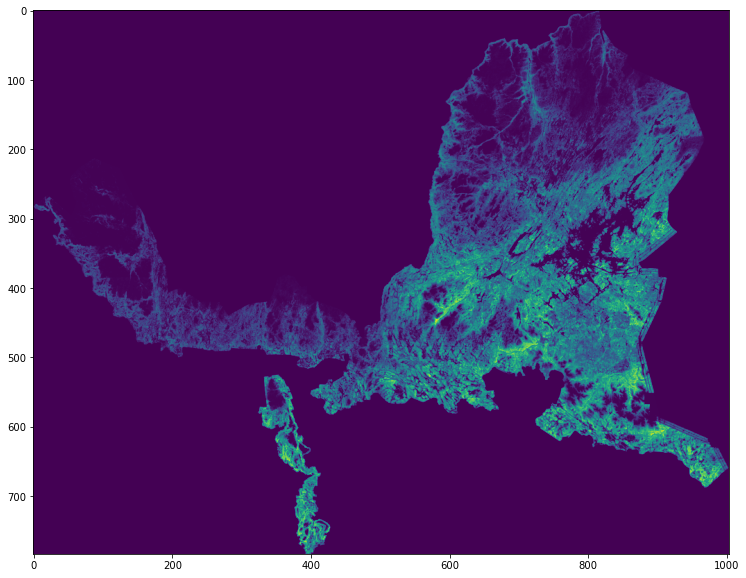

In [17]:
# Show the area to be classified - might take a few seconds
def da_coarsen(x, maxlen=200):
    cc = int(np.max(x.shape)/maxlen)
    return da.coarsen(np.mean, x, {0:cc, 1:cc}, trim_excess=True)

fig,ax = plt.subplots(figsize=(20,10))
F_coarse = da_coarsen(da.asarray(Fx[0]), maxlen=1000).compute()
ax.imshow(F_coarse)

In [18]:
from skimage.color import label2rgb

def full_inference_numpy(A, clf):
    # Reshaping
    A0 = np.moveaxis(A,0,2)
    ny, nx, chan = A0.shape
    a = A0.reshape(ny*nx, chan)

    # Classification
    c0 = clf.predict_proba(a)
    c = (254*c0).astype(np.uint8)

    # Inverse reshaping
    C = c.reshape(ny,nx, -1)
    C = np.moveaxis(C,2,0)
 
    return C

def full_inference(A: dask.array, clf) -> dask.array:
    # Reshaping
    A0 = da.moveaxis(A,0,2)
    ny, nx, chan = A0.shape
    a = A0.reshape(ny*nx, chan)

    # Classification
    c0 = clf.predict_proba(a)
    c = (254*c0).astype(np.uint8)

    # Inverse reshaping
    C = c.reshape(ny,nx, -1)
    C = da.moveaxis(C,2,0)
 
    return C

def inference(a: dask.array, clf) -> dask.array:
    c0 = clf.predict_proba(a)
    c = (254*c0).astype(np.uint8)
    return c

def read_masked_data(A: dask.array):
    """ Picks nonzero values along depth from A and returns rows of nonzero values
    and their index mask
    
    Performance depends highly on the mask rechunking size. If the chunk size is too large, memory 
    use per worker is too high, and if it is too low, chunks are probably copied across workers so
    that system memory usage is too high and SLURM job crashes.
    
    params
    A : array
    
    returns
    data: nonzero rows
    mask: row locations
    """

    A0 = da.moveaxis(A,0,2)
    ny, nx, chan = A0.shape
    a = A0.reshape(ny*nx, chan)

    mask = da.where(~da.all(a==0,axis=1))[0]
    mask.compute_chunk_sizes()
    mask = mask.rechunk((1e6,-1)) #inference float chunks get too big otherwise
    
    data = a[mask,:]
    return data, mask

def masked_inference(A: dask.array, clf)->dask.array:
    """Classifies an array depth-wise 
    """
    
    # Masking
    data, mask = read_masked_data(A)
    
    # New data
    chan, ny, nx = A.shape
    c = da.zeros((ny*nx, len(clf.classes_)), dtype=np.uint8) #empty array for results
    
    # Inference
    if len(data)!=0:
        c0 = inference(data, clf)
        c[mask,:] = c0

    # Inverse reshape
    C = c.reshape(ny,nx, -1)
    C = da.moveaxis(C,2,0)
    
    return C

def block_map(x):
    if not da.all(x == da.zeros_like(x)):
        return full_inference(x, clf)
    else:
        return da.zeros((len(classes), x.shape[1], x.shape[2])).astype(np.uint8)

In [19]:
def read_chunks(D: da.Array):
    """Reads chunks and their coordinates from a larger Dask array
    into a list
    """

    chunks = []
    coords = []
    x0 = 0
    x1 = 0
    y0 = 0
    y1 = 0
    # "normal" block shape for coordinate calculation
    base_shape = D.blocks[(0,0,0)].shape
    print("Reading chunks...")
    for inds in tqdm(itertools.product(*map(range, D.blocks.shape)),
                     total=np.product(D.blocks.shape)):
        # read chunk
        chunk = D.blocks[inds]
        chunks.append(chunk)

        # upper left corner
        x0 = (inds[2])*base_shape[2]
        y0 = (inds[1])*base_shape[1]

        # lower right corner
        x1 = x0 + chunk.shape[2]
        y1 = y0 + chunk.shape[1]
        coords.append({'x0':x0,
                       'x1':x1,
                       'y0':y0,
                       'y1':y1})
    return chunks, coords

def chunk_mapping(func, chunks):
    """maps a function to a list of dask arrays
    """
    out_chunks = []
    for chunk in tqdm(chunks):
        out_chunks.append(func(chunk))
    return out_chunks

def preprocess_arrays(X: xr.DataArray, func):
    """Turns a Xarray DataArray into a Dask array, reads it to chunks
    and applies a function on the chunks
    
    Returns:
        C_list: list of chunks with the function lazily applied
        X_list: list of the corresponding original xarray chunks
    """
    D = da.asarray(X)
    chunks, coords = read_chunks(D)
    C_list = chunk_mapping(func, chunks)
    X_list = [X[:,c['y0']:c['y1'], c['x0']:c['x1']] for c in coords]
    return C_list, X_list

In [20]:
from pathlib import Path
out_folder = Path(f'tulkinta-{timestamp}')
out_folder_temp = Path(f'tulkinta-{timestamp}-temp')

out_folder.mkdir(exist_ok=True)
out_folder_temp.mkdir(exist_ok=True)
start_i = 0

In [21]:
def produce_aggregate_maps(C):
    S = C.argmax(axis=0).astype(np.uint8)
    M = C.max(axis=0)
    return S,M

In [22]:
new_3d_xda = lambda c, d: xr.DataArray(c, 
                                       name='classification', 
                                       coords={'class': np.arange(len(classes)), 
                                               'y': d.y, 
                                               'x': d.x},
                                       dims=('class', 'y', 'x'))
new_2d_xda = lambda c, d: xr.DataArray(c, 
                                       coords={'y': d.y, 
                                               'x': d.x}, 
                                       dims=('y', 'x'))

def save_raster(x, name):
    if not da.all(x == da.zeros_like(x)):
        x.rio.to_raster(name, 
                       compress='LZW',
                       crs="EPSG:3067",
                       tiled=True,
                       windowed=True)

In [23]:
# Lazily applies the classification function to an xarray. No computation yet
C_list, X_list = preprocess_arrays(Fx.chunk((-1,1024,1024)), block_map)

Reading chunks...


  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/1008 [00:00<?, ?it/s]

In [24]:
## If the notebook crashes, change these to the previous folder name and uncomment
## Also, check the latest saved chunk index from the timestamped folder and set 'start_i' as it to continue.

#out_folder = Path('tulkinta-2022-07-06T16-24-17')
#out_folder_temp = Path(str(out_folder) + '-temp')

#start_i = 0

In [25]:
%%time
# Performs the computation and saves results to disk

for i in tqdm(range(start_i,len(C_list))):
    C = C_list[i]
    X = X_list[i]
    
    C = C.persist()
    X = X.persist()
    S, M = produce_aggregate_maps(C)
    
    outC = new_3d_xda(C, X)
    outS = new_2d_xda(S, X)
    outM = new_2d_xda(M, X)
    
    save_raster(outC, out_folder_temp / f'C_{i:05d}.tif')
    save_raster(outS, out_folder_temp / f'S_{i:05d}.tif')
    save_raster(outM, out_folder_temp / f'M_{i:05d}.tif')
    #client.compute(compute(C,X,i))

  0%|          | 0/1008 [00:00<?, ?it/s]

CPU times: total: 15h 6min 39s
Wall time: 14h 47min 12s


```
Runtimes
Full area Random Forest:

CPU times: total: 9h 52min 3s
Wall time: 4h 34min 44s


4000 x 4000 area:
CPU times: total: 9min 27s
Wall time: 10min 49s
```

### GDAL merging the output

In [26]:
!echo $out_folder

tulkinta-2022-07-08T12-51-57


In [27]:
!dir /b /s $out_folder_temp\C_*.tif > $out_folder\C_files.txt
!dir /b /s $out_folder_temp\S_*.tif > $out_folder\S_files.txt
!dir /b /s $out_folder_temp\M_*.tif > $out_folder\M_files.txt

In [28]:
!gdalbuildvrt -input_file_list $out_folder\C_files.txt $out_folder\C.vrt -a_srs EPSG:3067
!gdalbuildvrt -input_file_list $out_folder\S_files.txt $out_folder\S.vrt -a_srs EPSG:3067
!gdalbuildvrt -input_file_list $out_folder\M_files.txt $out_folder\M.vrt -a_srs EPSG:3067

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [29]:
!python E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\Scripts\gdal_merge.py $out_folder\C.vrt -o $out_folder\C.tif -co "COMPRESS=LZW" -co "BIGTIFF=YES" -co "TILED=YES" -ot "UInt16"
!python E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\Scripts\gdal_merge.py $out_folder\S.vrt -o $out_folder\S.tif -co "COMPRESS=LZW" -co "BIGTIFF=YES" -co "TILED=YES" -ot "UInt16"
!python E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\Scripts\gdal_merge.py $out_folder\M.vrt -o $out_folder\M.tif -co "COMPRESS=LZW" -co "BIGTIFF=YES" -co "TILED=YES" -ot "UInt16"

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [30]:
## The temp-file folder can be now deleted manually

### Change the band names to classes and create colormap

In [31]:
# Metadata info
with open(out_folder / 'metadata.txt', 'w') as f:
    f.write(f'Raster path: {RASTER_PATH}\n')
    f.write(f'Training data path: {TRAINDATA_PATH}\n')
    f.write(f'Model: {str(clf)}')

In [32]:
# you can load the colormap in QGIS for the S.tif to display 
# class names in the legend
cm = plt.get_cmap('tab20')
def create_qgis_colormap(outname, classes):
    with open(outname, 'w') as f:
        for i, classname in enumerate(classes):
            rgb = list((np.array(cm(i))*255).astype(np.uint8))
            f.write(str(i) + ' ')
            f.writelines([str(x) + ' ' for x in rgb])
            f.write(str(classname) + '\n')
create_qgis_colormap(out_folder / 'cmap.txt', classes)

In [33]:
# Writes class names to a file to be applied to the C.tif bands
with open(out_folder / 'classes.txt', 'w') as f:
    f.writelines([str(x)+'\n' for x in classes])

In [34]:
!python set_band_description.py $out_folder\C.tif $out_folder\classes.txt

In [35]:
client.close()